## Assignment 2: Linear predictors using gene expression 

1. Multiple Linear Modeling
    - How does gene expression in brain samples differ from blood samples?
        - predictor: tissue type
        - adjusted for **age and sex**
2. Logistic Modeling
    - Can gene expression from blood samples predict sex?
        - predictor: gene expression in **blood samples** only
        - outcome: sex

12/9/25 <br>
author: @emilyekstrum

In [53]:
# load required modules
import gzip, pandas as pd, numpy as np, requests, os, gc
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from statsmodels.stats.multitest import multipletests
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import seaborn as sns

### Load in GTEx Data

In [54]:
# download and load GTEx data files
files = {
    # GTEx gene expression data
    'GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz': 'https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz',
    
    # GTEx metadata files
    'GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt': 'https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt',
    'GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt': 'https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt'
}

# download files 
for filepath, url in files.items():
    if not os.path.exists(filepath):
        try:
            urlretrieve(url, filepath)
        except Exception as e:
            print(f"Error: {e}")
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(filepath, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            else:
                print(f"Failed to download. {response.status_code}")
    else:
        print(f"{filepath} already exists")

GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz already exists
GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt already exists
GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt already exists


In [55]:
# load and process gene expression data
with gzip.open('GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz', 'rt') as f:
    gene_exp_df = pd.read_csv(f, sep='\t', skiprows=2)

# look at the shape of the gene expression dataframe
print(f"Gene expression dataset shape: {gene_exp_df.shape}")

Gene expression dataset shape: (56200, 17384)


In [56]:
# get top 500 most variable genes (reduced for computation time)
gene_variances = gene_exp_df.select_dtypes(include=['number']).var(axis=1)
top_genes = gene_variances.nlargest(500).index
gene_exp_df = gene_exp_df.loc[top_genes]
print(f"Top 500 dataset shape: {gene_exp_df.shape}")

Top 500 dataset shape: (500, 17384)


In [57]:
# load metadata files
sample_metadata_df = pd.read_csv('GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt', sep='\t')
phenotype_metadata_df = pd.read_csv('GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt', sep='\t')
print(f"Sample metadata: {sample_metadata_df.shape}")
print(f"Phenotype metadata: {phenotype_metadata_df.shape}")

Sample metadata: (22951, 63)
Phenotype metadata: (980, 4)


In [58]:
# merge datasets 
# melt gene expression to long format
melted_df = pd.melt(gene_exp_df, id_vars=['Name', 'Description'], var_name='SampleID', value_name='TPM')

# merge with sample metadata based on sampleID
merged_df = melted_df.merge(sample_metadata_df, left_on='SampleID', right_on='SAMPID')

# merge with phenotype metadata based on subjectID
merged_df = merged_df.merge(phenotype_metadata_df, left_on=merged_df['SAMPID'].str.slice(0,10), right_on='SUBJID')

# standardize TPM values
scaler = StandardScaler()
merged_df['TPM_scaled'] = scaler.fit_transform(merged_df[['TPM']])

# clean memory for better computation time
del melted_df, gene_exp_df, gene_variances
gc.collect()

58

## 1. Multiple Linear Modeling

In [59]:
# filter for blood and brain samples only
blood_brain_df = merged_df[merged_df['SMTSD'].str.contains('Blood|Brain', case=False, na=False)].copy()

# check for only brain and blood samples
print(f"Blood/Brain tissue types: {blood_brain_df['SMTSD'].unique()}")

Blood/Brain tissue types: ['Brain - Cortex' 'Brain - Cerebellum' 'Whole Blood'
 'Brain - Frontal Cortex (BA9)' 'Brain - Caudate (basal ganglia)'
 'Brain - Nucleus accumbens (basal ganglia)'
 'Brain - Putamen (basal ganglia)' 'Brain - Hypothalamus'
 'Brain - Spinal cord (cervical c-1)' 'Brain - Hippocampus'
 'Brain - Anterior cingulate cortex (BA24)'
 'Brain - Cerebellar Hemisphere' 'Brain - Substantia nigra'
 'Brain - Amygdala']


In [60]:
# create binary variables and clean data to remove NA values
blood_brain_df['tissue_binary'] = blood_brain_df['SMTSD'].str.contains('Brain', case=False).astype(int)
blood_brain_df['sex_binary'] = (blood_brain_df['SEX'] == 1).astype(int)

In [61]:
# convert age ranges to numeric
def convert_age(age_str):
    ''' Convert age ranges to numeric values by averaging the range'''
    if pd.isna(age_str): return np.nan
    if '-' in str(age_str):
        start, end = str(age_str).split('-')
        return (int(start) + int(end)) / 2
    return float(age_str)

blood_brain_df['age_numeric'] = blood_brain_df['AGE'].apply(convert_age)
blood_brain_df = blood_brain_df.dropna(subset=['age_numeric', 'sex_binary'])

### Multiple linear regression model

In [62]:
# get unique genes
unique_genes = blood_brain_df['Name'].unique()

# sample 200 genes to speed up computation
if len(unique_genes) > 200:
    np.random.seed(42)
    sample_genes = np.random.choice(unique_genes, size=200, replace=False)
else:
    sample_genes = unique_genes

# process genes and store results in a list
results = []
for gene in sample_genes:
    gene_data = blood_brain_df[blood_brain_df['Name'] == gene]
    if len(gene_data) < 10: continue
    
    try:
        X = sm.add_constant(gene_data[['tissue_binary', 'age_numeric', 'sex_binary']])
        y = gene_data['TPM_scaled']
        model = sm.OLS(y, X).fit()
        
        results.append({
            'gene_name': gene,
            'gene_description': gene_data['Description'].iloc[0],
            'coefficient': model.params['tissue_binary'],
            'std_error': model.bse['tissue_binary'],
            't_statistic': model.tvalues['tissue_binary'],
            'p_value': model.pvalues['tissue_binary'],
            'ci_lower': model.conf_int().loc['tissue_binary', 0],
            'ci_upper': model.conf_int().loc['tissue_binary', 1],
            'r_squared': model.rsquared,
            'n_samples': len(gene_data)
        })
    except Exception as e:
        print(f"Error processing {gene}: {e}")

results_df = pd.DataFrame(results)
results_df['abs_coefficient'] = np.abs(results_df['coefficient'])

In [63]:
# multiple testing correction and results

if len(results_df) > 0:
    # FDR correction using alpha = 0.05
    rejected, pvals_corrected, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
    results_df['p_value_adjusted'] = pvals_corrected
    results_df['is_significant'] = rejected
    
    print(f"Significant genes after FDR correction: {results_df['is_significant'].sum()}/{len(results_df)}")
    
    # top 5 results
    print("\nTop 5 most significant results")
    
    # display top 5 results
    for _, row in results_df.nsmallest(5, 'p_value_adjusted').iterrows():
        direction = 'Higher in Brain' if row['coefficient'] > 0 else 'Higher in Blood'
        print(f"\n{row['gene_name']} - {row['gene_description']}")
        print(f"  Coefficient: {row['coefficient']:.4f} (95% CI: [{row['ci_lower']:.4f}, {row['ci_upper']:.4f}])")
        print(f"  Adjusted p-value: {row['p_value_adjusted']:.2e}")
        print(f"  Effect: {direction}, R^2: {row['r_squared']:.4f}")
    
    # summary stats
    significant = results_df[results_df['is_significant']]
    if len(significant) > 0:
        brain_higher = len(significant[significant['coefficient'] > 0])
        blood_higher = len(significant[significant['coefficient'] < 0])
        print(f"\n\nSummary: {brain_higher} genes higher in brain, {blood_higher} higher in blood")
    else:
        print("\n\nNo significant genes significance after FDR correction.")
else:
    print("No results available.")

Significant genes after FDR correction: 167/200

Top 5 most significant results

ENSG00000216490.3 - IFI30
  Coefficient: -0.2219 (95% CI: [-0.2274, -0.2163])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Blood, R^2: 0.7160

ENSG00000163220.10 - S100A9
  Coefficient: -6.1120 (95% CI: [-6.3741, -5.8499])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Blood, R^2: 0.4975

ENSG00000161638.10 - ITGA5
  Coefficient: -0.0105 (95% CI: [-0.0108, -0.0102])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Blood, R^2: 0.6691

ENSG00000198804.2 - MT-CO1
  Coefficient: 8.1895 (95% CI: [7.8402, 8.5388])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Brain, R^2: 0.4720

ENSG00000206503.12 - HLA-A
  Coefficient: -0.4590 (95% CI: [-0.4703, -0.4477])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Blood, R^2: 0.7260


Summary: 84 genes higher in brain, 83 higher in blood


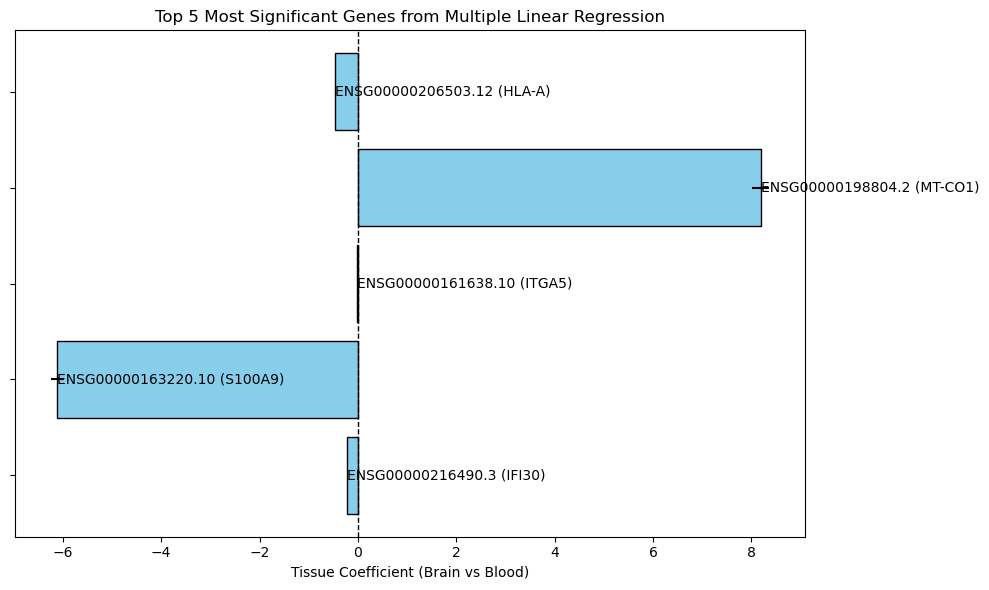

In [64]:
# plot results of the top 5 most significant genes
top_5_genes = results_df.nsmallest(5, 'p_value_adjusted')

plt.figure(figsize=(10, 6))
for i, (_, row) in enumerate(top_5_genes.iterrows()):
    plt.barh(i, row['coefficient'], xerr=row['std_error'], color='skyblue', edgecolor='black')
    plt.text(row['coefficient'], i, f"{row['gene_name']} ({row['gene_description']})", va='center', fontsize=10)

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.yticks(range(len(top_5_genes)), [])
plt.xlabel('Tissue Coefficient (Brain vs Blood)')
plt.title('Top 5 Most Significant Genes from Multiple Linear Regression')
plt.tight_layout()
plt.show()

In [65]:
# top 5 results with the largest effect size
print("Top 5 results with the largest effect size")
for _, row in results_df.nlargest(5, 'abs_coefficient').iterrows(): 
    direction = 'Higher in Brain' if row['coefficient'] > 0 else 'Higher in Blood'
    print(f"\n{row['gene_name']} - {row['gene_description']}")
    print(f"  Coefficient: {row['coefficient']:.4f} (95% CI: [{row['ci_lower']:.4f}, {row['ci_upper']:.4f}])")
    print(f"  Adjusted p-value: {row['p_value_adjusted']:.2e}")
    print(f"  Effect: {direction}, R^2: {row['r_squared']:.4f}")


Top 5 results with the largest effect size

ENSG00000244734.3 - HBB
  Coefficient: -47.9651 (95% CI: [-49.0468, -46.8834])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Blood, R^2: 0.7472

ENSG00000188536.12 - HBA2
  Coefficient: -14.2006 (95% CI: [-14.5216, -13.8796])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Blood, R^2: 0.7451

ENSG00000198712.1 - MT-CO2
  Coefficient: 9.3728 (95% CI: [9.1428, 9.6028])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Brain, R^2: 0.7230

ENSG00000198804.2 - MT-CO1
  Coefficient: 8.1895 (95% CI: [7.8402, 8.5388])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Brain, R^2: 0.4720

ENSG00000198886.2 - MT-ND4
  Coefficient: 7.5014 (95% CI: [7.3097, 7.6930])
  Adjusted p-value: 0.00e+00
  Effect: Higher in Brain, R^2: 0.7099


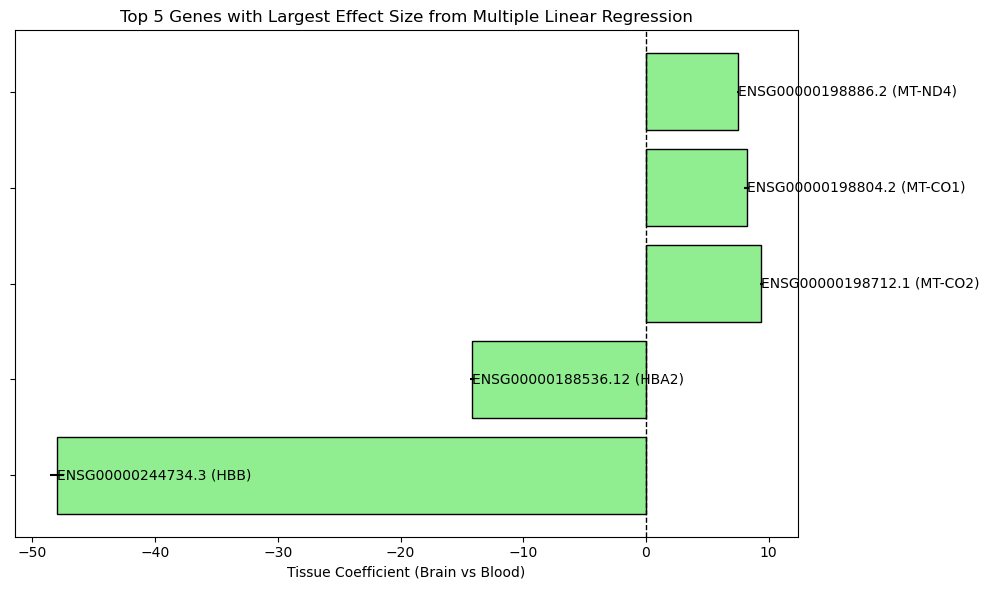

In [66]:
# plot results of the top 5 genes with the largest effect size
top_5_effect_size = results_df.nlargest(5, 'abs_coefficient')
plt.figure(figsize=(10, 6))
for i, (_, row) in enumerate(top_5_effect_size.iterrows()):
    plt.barh(i, row['coefficient'], xerr=row['std_error'], color='lightgreen', edgecolor='black')
    plt.text(row['coefficient'], i, f"{row['gene_name']} ({row['gene_description']})", va='center', fontsize=10)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.yticks(range(len(top_5_effect_size)), [])
plt.xlabel('Tissue Coefficient (Brain vs Blood)')
plt.title('Top 5 Genes with Largest Effect Size from Multiple Linear Regression')
plt.tight_layout()
plt.show()

## Multiple linear regression model interpretation

According to the multiple linear regression model that predicts tissue type based on blood and brain samples (adjusted for age and sex), the top 5 most significant genes do not notably overlap with the top 5 genes that have the largest effect size. 

The most significant genes identified are IFI30 (p-val = <1e-16), S100A9 (p-val = <1e-16), ITGA5 (p-val = <1e-16), MT-CO1 (p-val = <1e-16), and HLA-A (p-val = <1e-16). Three out of five of the most significant genes for predicting tissue type are involved in immune processes, including antigen breakdown (IFI30), inflammation biomarker (S100A9), and antigen presentation stabilizing scaffolding (HLA-A). The other two top significant genes encode proteins that are involved in the electron transport chain (MT-CO1) and extracellular matrix stability (ITGA5).

The genes with the greatest effect size the model identifed encode proteins vital for hemoglobin production (HBB effect R^2 = 0.7472, HBA effect R^2 = 0.7451). Logically, these genes had higher effect sizes in blood samples. This suggests that genes that are important for hemoglobin production are strongly related to blood tissue samples. 
The remaining 3 genes with the greatest effect size were higher in brain tissue, and encode for a class of mitochondiral proteins in cytochrome c oxidase complexes (MT-CO2 effect R^2 = 0.7230, MT-CO1 effect R^2 = 0.4720) and NADH:Ubiquinone oxidoreducatase core subunit 4 (MT-ND4 effect R^2 = 0.7099). This indicates that genes that encode for protein products involved in the electron transport chain have a strong relationship with neural tissue in this dataset.

The only gene that was in both the genes with the greatest significance and effect size was MT-CO1. This suggests that MT-CO1 is closely related to brain tissues and is an important explanatory variable that discriminates between brain and blood tissue. 

## 2. Logistic Modeling

In [67]:
# logistic regression model - includes blood samples only for sex prediction
# filter for blood samples only
blood_only_df = merged_df[merged_df['SMTSD'].str.contains('Blood', case=False, na=False)].copy()
print(f"Total blood samples: {len(blood_only_df)}")

# create sex binary variable and clean data
blood_only_df['sex_binary'] = (blood_only_df['SEX'] == 1).astype(int)

# convert age ranges to numeric
blood_only_df['age_numeric'] = blood_only_df['AGE'].apply(convert_age)
blood_only_df = blood_only_df.dropna(subset=['age_numeric', 'sex_binary'])

print(f"Blood samples after preprocessing: {len(blood_only_df)}")
print(f"Sex distribution - Male (1): {blood_only_df['sex_binary'].sum()}, Female (0): {len(blood_only_df) - blood_only_df['sex_binary'].sum()}")

Total blood samples: 256500
Blood samples after preprocessing: 256500
Sex distribution - Male (1): 173500, Female (0): 83000


In [68]:
# get top 5000 most variable genes in blood samples

# calculate variance for each gene in blood samples only
blood_gene_variances = []
unique_genes = blood_only_df['Name'].unique()

for gene in unique_genes:
    gene_data = blood_only_df[blood_only_df['Name'] == gene]['TPM']
    if len(gene_data) > 10:  # use at least 10 samples
        variance = gene_data.var()
        blood_gene_variances.append({'gene': gene, 'variance': variance})

# convert to dataframe and get top 5000 genes
variance_df = pd.DataFrame(blood_gene_variances)
top_5k_genes = variance_df.nlargest(min(5000, len(variance_df)), 'variance')['gene'].tolist()

# filter blood data to top 5000 variant genes
blood_top5k_df = blood_only_df[blood_only_df['Name'].isin(top_5k_genes)].copy()
print(f"Final dataset shape for logistic regression: {blood_top5k_df.shape}")

Final dataset shape for logistic regression: (256500, 74)


In [69]:
# logistic regression analysis for sex prediction in blood samples
logistic_results = []
analysis_genes = top_5k_genes

# limit number of genes used for reduced computation time
if len(analysis_genes) > 1000:
    np.random.seed(42)
    analysis_genes = np.random.choice(analysis_genes, size=1000, replace=False)
    print(f"Randomly sampling {len(analysis_genes)} genes from top 5000 for analysis")

print(f"Using {len(analysis_genes)} genes for sex prediction in blood sanmples using logistic regression")

Using 500 genes for sex prediction in blood sanmples using logistic regression


### Logistic regression model 

In [70]:
# run logistic regression for each gene
for i, gene in enumerate(analysis_genes):
    if i % 100 == 0:
        print(f"Running log reg on gene {i+1}/{len(analysis_genes)}")
    
    gene_data = blood_top5k_df[blood_top5k_df['Name'] == gene]
    if len(gene_data) < 20: continue  # require at least 20 samples
    
    try:
        # fit logistic model
        model = logit('sex_binary ~ TPM_scaled + age_numeric', data=gene_data).fit(disp=0)
        
        # get TPM coefficient 
        tmp_coef = model.params['TPM_scaled']
        tmp_pval = model.pvalues['TPM_scaled']
        tmp_se = model.bse['TPM_scaled']
        
        logistic_results.append({
            'gene_name': gene,
            'gene_description': gene_data['Description'].iloc[0],
            'tmp_coefficient': tmp_coef,
            'tmp_std_error': tmp_se,
            'tmp_p_value': tmp_pval,
            'odds_ratio': np.exp(tmp_coef),
            'pseudo_r2': model.prsquared,
            'n_samples': len(gene_data)
        })
    except Exception as e:
        continue  # skip genes that don't to converge 

logistic_results_df = pd.DataFrame(logistic_results)

Running log reg on gene 1/500
Running log reg on gene 101/500
Running log reg on gene 201/500
Running log reg on gene 301/500


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_70302/707258337.py:24: RuntimeWarning: overflow encountered in exp
  'odds_ratio': np.exp(tmp_coef),
/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_70302/707258337.py:24: RuntimeWarning: overflow encountered in exp
  'odds_ratio': np.exp(tmp_coef),
/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_70302/707258337.py:24: RuntimeWarning: overflow encountered in exp
  'odds_ratio': np.exp(tmp_coef),


Running log reg on gene 401/500


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_70302/707258337.py:24: RuntimeWarning: overflow encountered in exp
  'odds_ratio': np.exp(tmp_coef),
/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_70302/707258337.py:24: RuntimeWarning: overflow encountered in exp
  'odds_ratio': np.exp(tmp_coef),
/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_70302/707258337.py:24: RuntimeWarning: overflow encountered in exp
  'odds_ratio': np.exp(tmp_coef),
/opt/anaconda3/envs/cu-cpbs-7602/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_70302/707258337.py:24: RuntimeWarning: overflow encountered in exp
  'odds_ratio': np.exp(tmp_coef),
/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_70302/707258337.py:24: RuntimeWarning: overflow encounter

In [71]:
# FDR correction
if len(logistic_results_df) > 0:
    # FDR correction on TPM p-values
    rejected, pvals_corrected, _,_ = multipletests(logistic_results_df['tmp_p_value'], alpha=0.05, method='fdr_bh')
    logistic_results_df['tmp_p_value_adjusted'] = pvals_corrected
    logistic_results_df['is_significant'] = rejected
    
    print(f"Significant genes for sex prediction after FDR correction: {logistic_results_df['is_significant'].sum()}/{len(logistic_results_df)}")
    
    # display top results
    print("Top 5 Genes most predictive of sex in blood samples")
    
    for i, (_, row) in enumerate(logistic_results_df.nsmallest(5, 'tmp_p_value_adjusted').iterrows()):
        sex_effect = 'Higher expression in Males' if row['tmp_coefficient'] > 0 else 'Higher expression in Females'
        print(f"\n{i+1}. {row['gene_name']} - {row['gene_description']}")
        print(f"   Coefficient: {row['tmp_coefficient']:.4f} (SE: {row['tmp_std_error']:.4f})")
        print(f"   Odds Ratio: {row['odds_ratio']:.4f}")
        print(f"   Adjusted p-value: {row['tmp_p_value_adjusted']:.2e}")
        print(f"   Effect: {sex_effect}")
    
    # summary statistics
    significant = logistic_results_df[logistic_results_df['is_significant']]
    if len(significant) > 0:
        male_higher = len(significant[significant['tmp_coefficient'] > 0])
        female_higher = len(significant[significant['tmp_coefficient'] < 0])
        print("\nSummary:")
        print(f"Total significant genes: {len(significant)}")
        print(f"Genes with higher expression in males: {male_higher}")
        print(f"Genes with higher expression in females: {female_higher}")
        print(f"Median odds ratio: {significant['odds_ratio'].median():.4f}")
        print(f"Range of odds ratios: {significant['odds_ratio'].min():.4f} - {significant['odds_ratio'].max():.4f}")
    else:
        print("\n\nNo significant genes for sex prediction after FDR correction.")
else:
    print("\nNo logistic regression results available.")

Significant genes for sex prediction after FDR correction: 25/499
Top 5 Genes most predictive of sex in blood samples

1. ENSG00000115705.20 - TPO
   Coefficient: 1016320.1771 (SE: 108365.5916)
   Odds Ratio: inf
   Adjusted p-value: 3.34e-18
   Effect: Higher expression in Males

2. ENSG00000203859.9 - HSD3B2
   Coefficient: -1385992.2828 (SE: 214036.0486)
   Odds Ratio: 0.0000
   Adjusted p-value: 2.36e-08
   Effect: Higher expression in Females

3. ENSG00000243480.7 - AMY2A
   Coefficient: -2144991.6600 (SE: 535022.7270)
   Odds Ratio: 0.0000
   Adjusted p-value: 1.01e-02
   Effect: Higher expression in Females

4. ENSG00000162747.9 - FCGR3B
   Coefficient: -2.5298 (SE: 0.6458)
   Odds Ratio: 0.0797
   Adjusted p-value: 1.12e-02
   Effect: Higher expression in Females

5. ENSG00000198034.10 - RPS4X
   Coefficient: -8.6124 (SE: 2.2574)
   Odds Ratio: 0.0002
   Adjusted p-value: 1.36e-02
   Effect: Higher expression in Females

Summary:
Total significant genes: 25
Genes with higher ex

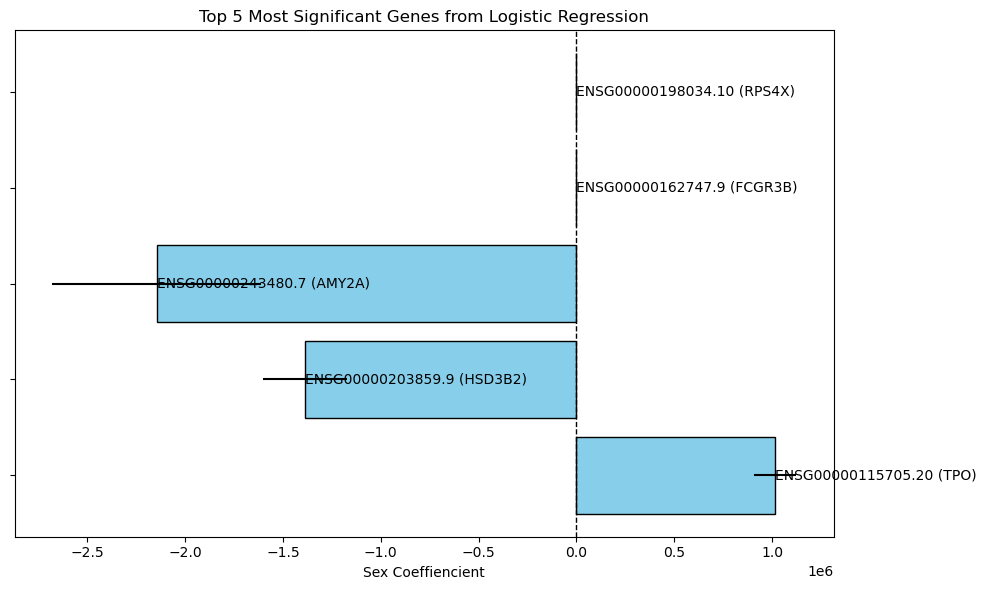

In [72]:
# Plot the results of the top 5 most significant genes
top_5_genes = logistic_results_df.nsmallest(5, 'tmp_p_value_adjusted')

plt.figure(figsize=(10, 6))
for i, (_, row) in enumerate(top_5_genes.iterrows()):
    plt.barh(i, row['tmp_coefficient'], xerr=row['tmp_std_error'], color='skyblue', edgecolor='black')
    plt.text(row['tmp_coefficient'], i, f"{row['gene_name']} ({row['gene_description']})", va='center', fontsize=10)

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.yticks(range(len(top_5_genes)), [])
plt.xlabel('Sex Coeffiencient')
plt.title('Top 5 Most Significant Genes from Logistic Regression')
plt.tight_layout()
plt.show()

In [73]:
# tep 5 logistic regression results with the largest effect size
print("Top 5 results with the largest effect size")
for _, row in logistic_results_df.nlargest(5, 'tmp_coefficient').iterrows(): 
    direction = 'Higher in Males' if row['tmp_coefficient'] > 0 else 'Higher in Females'
    print(f"\n{row['gene_name']} - {row['gene_description']}")
    print(f"  Coefficient: {row['tmp_coefficient']:.4f} (SE: {row['tmp_std_error']:.4f})")
    print(f"  Adjusted p-value: {row['tmp_p_value_adjusted']:.2e}")
    print(f"  Effect: {direction}), Odds Ratio: {row['odds_ratio']:.4e}") 


Top 5 results with the largest effect size

ENSG00000115705.20 - TPO
  Coefficient: 1016320.1771 (SE: 108365.5916)
  Adjusted p-value: 3.34e-18
  Effect: Higher in Males), Odds Ratio: inf

ENSG00000143954.12 - REG3G
  Coefficient: 965242.3617 (SE: 928268.1683)
  Adjusted p-value: 7.10e-01
  Effect: Higher in Males), Odds Ratio: inf

ENSG00000171209.3 - CSN3
  Coefficient: 61925.1852 (SE: 55507.9027)
  Adjusted p-value: 7.03e-01
  Effect: Higher in Males), Odds Ratio: inf

ENSG00000167531.6 - LALBA
  Coefficient: 12172.4416 (SE: 44443.1950)
  Adjusted p-value: 9.12e-01
  Effect: Higher in Males), Odds Ratio: inf

ENSG00000152266.6 - PTH
  Coefficient: 5897.9227 (SE: 72850.6189)
  Adjusted p-value: 9.69e-01
  Effect: Higher in Males), Odds Ratio: inf


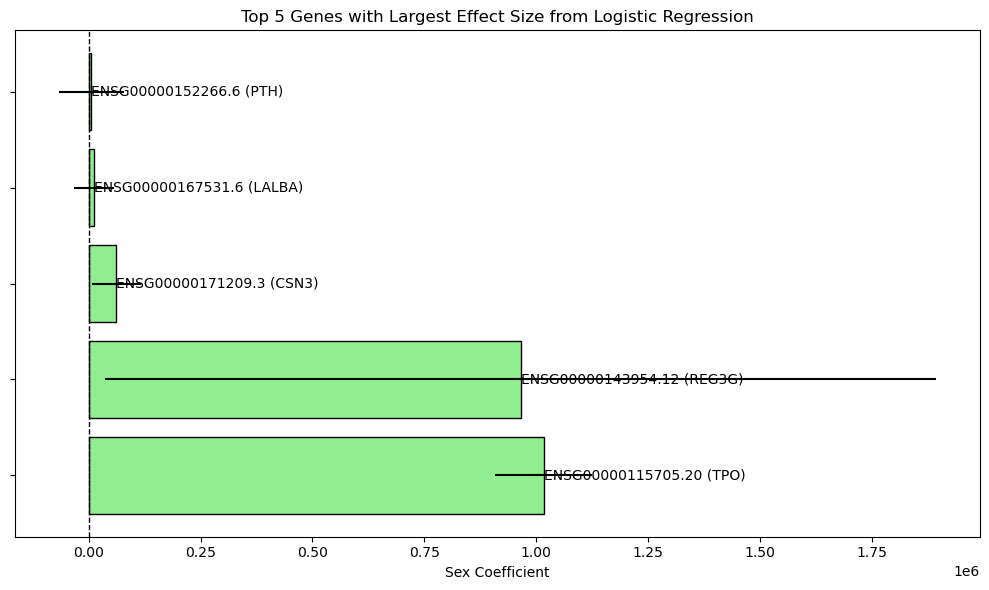

In [74]:
# plot results of the top 5 genes with the largest effect size
top_5_effect_size = logistic_results_df.nlargest(5, 'tmp_coefficient')
plt.figure(figsize=(10, 6))
for i, (_, row) in enumerate(top_5_effect_size.iterrows()):
    plt.barh(i, row['tmp_coefficient'], xerr=row['tmp_std_error'], color='lightgreen', edgecolor='black')
    plt.text(row['tmp_coefficient'], i, f"{row['gene_name']} ({row['gene_description']})", va='center', fontsize=10)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.yticks(range(len(top_5_effect_size)), [])
plt.xlabel('Sex Coefficient')
plt.title('Top 5 Genes with Largest Effect Size from Logistic Regression')
plt.tight_layout()
plt.show()

## Logistic regression model interpretation

Similarly to the multiple linear regression model, only one gene for the logitistic regression model that predicts sex based on highly variable gene expression data from blood samples is identified in both the top 5 most significant genes and the top 5 genes with the greatest effect size for the model. 

The most siginifcant genes for the logisitc regression model for binary sex prediction are TPO (p-val = 3.34e-18), HSD3B2 (p-val = 2.36e-08), AMY2A (p-val = 1.01e-02), FCGR3B (p-val = 1.12e-02), and RPS4X (p-val = 1.36e-02). The top two most significant genes (TPO and HSD3B2) encode for proteins that are involved in hormone production. These two genes are logical predictors for sex, as hormone levels and production are distinct processes between males and females. AMY2A gene product is involved in amylase production, FCGR3B encodes for immune receptors, and RPS4X encodes proteins that are essential for ribosomal function. 

The genes with the greatest effect sizes include TPO, REG3G, CSN3, LALBA, and PTH, all with effects that are greater in males. TPO gene products are involved in thyroid hormone production, REG3G products are involved in immune processes in the digestive system, CSN3 products are involved in mammary gland processes, LALBA gene products are subunits for lactose production, and PTH encodes for proteins that aid in hormone regulation. Similar to the top 5 most siginificant genes identified, the genes that have the greatest effect size for predicting sex based on blood samples are associated with hormonal processes that logically should be different between males and females.

TPO was the only gene that was significant and had a large effect size. Thus, TPO is an important explanatory gene between sexes and has a strong relationship with males when using blood sample gene expression as features to predict sex.

Note: The model did not converge >350 genes. Troubleshooting by changing the solver and maxiter did not fix the issue. Thus, the genes that did not converge were skipped.
